# Validation of method

### Table of contents

1. [**SVGP**](#svgp)
3. [**SSGP**](#ssgp)
4. [**STGP**](#stgp)


This notebook contains code for:
- Investigating the number of inducing points and expressivity, degree of nonconvexity of GP models
- Multi-regressor tuning evaluation
- GP-GLM validation in population fitting
- GP marginal log-likelihood versus locally weighted log-likelihood model selection for kernel hyperparameters

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
sys.path.append("..")


import jax
import jax.numpy as jnp
import jax.random as jr
from jax.nn import softplus

import optax

jax.config.update('jax_platform_name', 'cpu')
#jax.config.update('jax_disable_jit', True)
jax.config.update("jax_enable_x64", True)

#import os
#if not os.path.exists('./saves'):
#    os.makedirs('./saves')


import pickle


import lib


import matplotlib.pyplot as plt
plt.style.use(['../paper.mplstyle'])

/var/home/dl543/Documents/Learning/nonparametric-modulated-renewal/notebooks/../lib/inference.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


<a id='hmm'></a>
## HMM

In [2]:
K = 3
pre_T = np.random.randn(K, K)
pre_T[1, 0] = 5.
#T = jax.nn.softmax(pT, axis=0)

ts = 1000
site_ll = np.random.randn(ts, K)

HMM = lib.GP.switching.HMM(pre_T, site_ll)

In [3]:
pi = HMM.compute_stationary_distribution()

In [4]:
num_samps = 10
prng_state = jr.PRNGKey(seed=123)

prior_samples = HMM.sample_prior(prng_state, num_samps, ts)

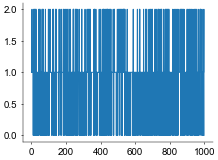

In [5]:
plt.plot(prior_samples[:, 1])

In [17]:
log_posts, KL, aux = HMM.evaluate_posterior(HMM.site_ll, compute_KL=True)

In [18]:
post_samples, KL = HMM.sample_posterior(prng_state, num_samps, ts, compute_KL=True)

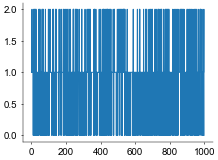

In [19]:
plt.plot(prior_samples[:, 1])

In [34]:
def bouncing_ball(s0, timesteps, delta_t, g = 9.81, coeff_restitution = 1.):
    """
    :param np.ndarray s0: initial state of shape (trials, dims)
    """
    trials, state_dims = s0.shape
    
    timeline = np.arange(timesteps+1) * delta_t
    s = np.empty((timesteps+1, trials, state_dims))
    s[0, ...] = s0
    for t in range(timesteps):
        s[t+1, :, 0] = s[t, :, 0] + delta_t * s[t, :, 1]
        s[t+1, :, 1] = s[t, :, 1] + delta_t * (-g)
        
        collides = np.where(s[t+1, :, 0] <= 0.)[0]
        for c in collides:
            s[t+1, c, 0] = 0.
            s[t+1, c, 1] = -coeff_restitution * s[t+1, c, 1]
    
    dataset = {
        'state': s, 
        'time': timeline, 
    }
    return dataset



def nonstationary_function(delta_t):
    T = 4000
    t = np.arange(T) * delta_t
    y = np.empty(T)
    
    y[:1000] = np.sin(t[:1000] * 20.)
    y[1000:2000] = t[:1000] - t[:1000]**2
    y[2000:3000] = t[:1000]**2 
    y[3000:] = 0.
    
    dataset = {
        'y': y, 
        't': t, 
    }
    return dataset

In [35]:
s0 = np.ones((3, 2)) + np.arange(3)[:, None]
s0[:, 1] = 0.
timesteps = 100000
delta_t = 0.0001

ds = bouncing_ball(s0, timesteps, delta_t, g = 9.81, coeff_restitution = 0.8)

In [36]:
y = ds['state'][..., 0]
v = ds['state'][..., 1]
t = ds['time']

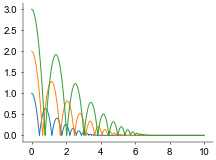

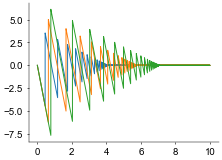

In [37]:
plt.plot(t, y)
plt.show()

plt.plot(t, v)
plt.show()

In [38]:
ds = nonstationary_function(delta_t = 0.001)

y = ds['y']
t = ds['t']

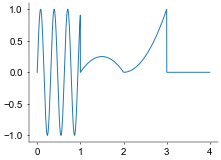

In [39]:
plt.plot(t, y)
plt.show()

### Generate data

generating some data ...


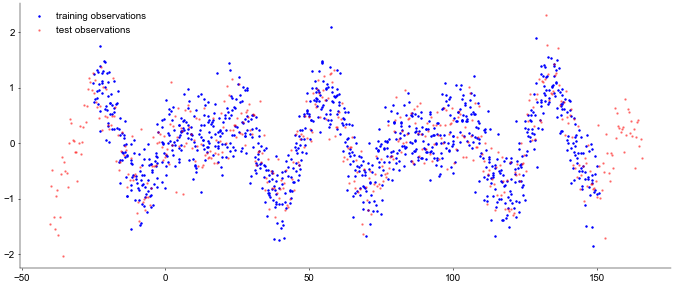

In [59]:
def wiggly_time_series(x):
    x_ = x[:, None]
    noise_var = np.array([0.15])  # true observation noise
    return (np.cos(0.04*x_+0.33*np.pi) * np.sin(0.2*x_) +
            np.sqrt(noise_var)[None, :] * np.random.normal(0, 1, x.shape+noise_var.shape))


print('generating some data ...')
np.random.seed(12345)

N = 1000
N_test = 500

# x = np.linspace(-25.0, 75.0, num=N)  # evenly spaced
x = np.random.permutation(np.linspace(-25.0, 150.0, N) + 0.5*np.random.randn(N))  # unevenly spaced
y = wiggly_time_series(x)
x_test = np.linspace(np.min(x)-15.0, np.max(x)+15.0, num=N_test)
y_test = wiggly_time_series(x_test)

plot_out = 0

plt.figure(1, figsize=(12, 5))
plt.plot(x, y[:, plot_out], 'b.', label='training observations')
plt.plot(x_test, y_test[:, plot_out], 'r.', alpha=0.4, label='test observations')
plt.legend()

### Build the GP model

In [219]:
out_dims = y.shape[1]

var_f = 1.0*np.ones(out_dims)  # GP variance
len_f = 5.0*np.ones(out_dims)  # GP lengthscale
var_y = 0.5*np.ones(out_dims)  # observation noise

#kernel = lib.kernels.Matern32(out_dims, variance=var_f, lengthscale=len_f)
# kernel_list = [lib.kernels.Matern52(1, variance=var_f[:1], lengthscale=len_f[:1]), 
#                lib.kernels.Matern32(1, variance=var_f[1:], lengthscale=len_f[1:])]
kernel = lib.kernels.Matern12(out_dims, variance=var_f, lengthscale=len_f)
#lib.kernels.Independent(kernel_list)

lik = lib.likelihoods.Gaussian(out_dims, variance=var_y)#Poisson(out_dims)#
lik.set_approx_integration(approx_int_method='GH', num_approx_pts=20)

#obs = lib.observations.Identity(out_dims, lik)
C = np.eye(out_dims)
b = np.zeros((out_dims,))
obs = lib.observations.Linear(out_dims, lik, [C, b])
#obs = lib.observations.Bayesian_Linear(out_dims, lik, [C, b])
obs.set_approx_integration(approx_int_method='MC', num_approx_pts=20)

model = lib.inference.NGD_SSGP(kernel, obs)
model.set_data(x, y)

### Optimise the hyperparameters and site parameters

In [220]:
plot_intermediate = False
print_every = 10
epochs = 500

# init
opt_init, opt_update, get_params = optimizers.adam(step_size=5e-1)
opt_state = opt_init(model.get_params())
inference_state = [jax.random.PRNGKey(123), 0.1, 1e-6] # PRNG state, CVI damping, jitter

In [221]:
print('optimising the hyperparameters ...')
t0 = time.time()

losses = []
for j in range(epochs):
    loss, gradients, inference_state = model.run_LML(inference_state) #run_ELBO(params)
    
    # gradient step
    opt_state = opt_update(j, gradients, opt_state)
    params = get_params(opt_state)
    model.set_params(params) # set new model parameters
    
    # annealing
    #inference_state[1] = np.maximum(inference_state[1]*.9, .01)
    
    if j == 0:
        print('iter %2d: loss=%.2f' % (j+1, loss))
    
    if ((j+1) % print_every) == 0:
        t1 = time.time()
        print('iter %2d: loss=%.2f | optimisation time: %.2f secs' % (j+1, loss, t1-t0))
        t0 = time.time()

    if plot_intermediate:
        plot_model(model, j)
        
    losses.append(loss)

optimising the hyperparameters ...
iter  1: loss=1173.54
iter 10: loss=573.92 | optimisation time: 3.13 secs
iter 20: loss=730.83 | optimisation time: 0.09 secs
iter 30: loss=753.88 | optimisation time: 0.09 secs
iter 40: loss=741.69 | optimisation time: 0.09 secs
iter 50: loss=681.05 | optimisation time: 0.09 secs
iter 60: loss=581.08 | optimisation time: 0.09 secs
iter 70: loss=557.52 | optimisation time: 0.09 secs
iter 80: loss=549.02 | optimisation time: 0.09 secs
iter 90: loss=567.24 | optimisation time: 0.09 secs
iter 100: loss=553.71 | optimisation time: 0.09 secs
iter 110: loss=548.34 | optimisation time: 0.09 secs
iter 120: loss=549.90 | optimisation time: 0.09 secs
iter 130: loss=549.58 | optimisation time: 0.09 secs
iter 140: loss=547.90 | optimisation time: 0.09 secs
iter 150: loss=547.92 | optimisation time: 0.09 secs
iter 160: loss=548.32 | optimisation time: 0.09 secs
iter 170: loss=548.03 | optimisation time: 0.09 secs
iter 180: loss=547.58 | optimisation time: 0.09 sec

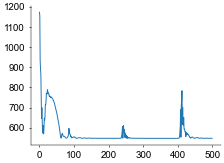

In [222]:
plt.plot(losses)

### Make predictions

In [223]:
num_samples = 20
x_plot = np.linspace(np.min(x)-20.0, np.max(x)+20.0, 200)

In [224]:
model.observation.set_approx_integration(approx_int_method='GH', num_approx_pts=20)
model.observation.likelihood.set_approx_integration(approx_int_method='GH', num_approx_pts=20)
prng_state = jax.random.PRNGKey(123) # when using MC for evaluation

In [225]:
print('calculating the posterior predictive distribution ...')
t0 = time.time()
nlpd = model.negative_log_predictive_density(prng_state, t=x_test, y=y_test)
posterior_mean, posterior_cov = model.posterior_predictive(prng_state, t=x_plot)
t1 = time.time()
print('prediction time: %2.2f secs' % (t1-t0))
print('test NLPD: %1.2f' % nlpd)

calculating the posterior predictive distribution ...
prediction time: 0.85 secs
test NLPD: 0.60


In [226]:
### Sample from the posterior distribution
print('sampling from the posterior ...')
t0 = time.time()
posterior_samp = model.sample_posterior(num_samples, prng_state, t=x_plot)
t1 = time.time()
print('sampling time: %2.2f secs' % (t1-t0))

sampling from the posterior ...
sampling time: 1.74 secs


In [ ]:
posterior_var = posterior_cov[:, np.arange(out_dims), np.arange(out_dims)]
lb = posterior_mean - 1.96 * posterior_var ** 0.5
ub = posterior_mean + 1.96 * posterior_var ** 0.5

for plot_out in range(out_dims):

    print('plotting ...')
    plt.figure(2, figsize=(12, 5))
    plt.clf()
    plt.plot(x, y[:, plot_out], 'k.', label='training observations')
    plt.plot(x_test, y_test[:, plot_out], 'r.', alpha=0.4, label='test observations')
    plt.plot(x_plot, posterior_mean[:, plot_out], 'b', label='posterior mean')
    plt.fill_between(x_plot, lb[:, plot_out], ub[:, plot_out], color='b', alpha=0.05, label='95% confidence')
    plt.plot(x_plot, posterior_samp[:, plot_out, :], 'b', alpha=0.15)
    plt.xlim([x_plot[0], x_plot[-1]])
    plt.legend()
    plt.title('GP regression via Kalman smoothing. Test NLPD: %1.2f' % nlpd)
    plt.xlabel('time $t$')
    plt.show()

plotting ...


In [310]:
model.likelihood.hyp

DeviceArray([-9.4332695], dtype=float32)

In [311]:
model.kernel.hyp

DeviceArray([[23.959751 , -6.3740187]], dtype=float32)